In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import math
import os
import platform

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [6]:
if platform.system() == "Darwin":
    print("Using MacOS.")
    data_folder = ""  
elif platform.system() == "Linux":
    print("Using Linux.")
    data_folder = os.path.normpath("/mnt/scratch07/yilong")
else:
    print("Using Windows.")
    data_folder = os.path.normpath("")
#     large_data_folder = os.path.normpath("D:\\Backup\\JET-Detection\\Heartbeats_dict_20220201\\")

Using MacOS.


In [9]:
patient_ID_list_train = [398573, 462229, 637891, 667681, 537854, 628521, 642321, 662493,
                         387479, 624179, 417349, 551554, 631270, 655769, 678877]  # 15
patient_ID_list_test = [756172, 424072, 748555, 748900, 759678, 741235, 595561, 678607,
                        782501, 510915, 771495, 740475, 533362, 581650, 803389, 577874,
                        681150, 536886, 477589, 844864, 824744, 515544, 771958, 725860, 609090]  # 25
patient_ID_list_val = [462229, 642321, 387479]  # 3
patient_ID_list_dev = [patient_ID for patient_ID in patient_ID_list_train if
                       patient_ID not in patient_ID_list_val]  # 12

In [7]:
load_training_data = False
if load_training_data:
    data_chunk_folder = "ecg-pat40-tch-sinus_jet_lead2"
    data_chunk_list = []
    for data_filename in os.listdir(os.path.join(data_folder, data_chunk_folder)):
        data_chunk_list.append(pd.read_csv(os.path.join(data_folder, data_chunk_folder, data_filename)))
    feature_df_all_selected_with_ecg = pd.concat(data_chunk_list, axis=0)
else:
    feature_df_all_selected_with_ecg = None
    
channel_ID = 2
feature_with_ecg_df_train_single_lead = feature_df_all_selected_with_ecg.query(f"patient_ID in {patient_ID_list_train}").query(f"channel_ID == {channel_ID}")

In [8]:
feature_with_ecg_df_val_single_lead = pd.read_csv("feature_with_ecg_df_val_lead2.csv")
feature_with_ecg_df_test_single_lead = pd.read_csv("feature_with_ecg_df_test_lead2.csv")
feature_with_ecg_df_test_single_lead

,cycle_ID,patient_ID,interval_ID,block_ID,channel_ID,segment_ID,start_ID,end_ID,r_ID,r_t,...,ecg295,ecg296,ecg297,ecg298,ecg299,ecg300,r_ID_abs,r_ID_abs_ref,selected,duration
0,1,771495,8748755,1,2,1,1,66705,820,2015-12-22 23:12:04.099549952,...,1.290715,1.403295,1.606575,1.857944,2.039397,2.014317,820,820,True,277.528
1,2,771495,8748755,1,2,1,1,66705,907,2015-12-22 23:12:04.461459968,...,1.152530,1.248552,1.434638,1.692337,1.924521,1.995100,907,907,True,277.528
2,3,771495,8748755,1,2,1,1,66705,994,2015-12-22 23:12:04.823380224,...,0.954466,1.053145,1.247815,1.520770,1.775172,1.874207,994,994,True,277.528
3,4,771495,8748755,1,2,1,1,66705,1085,2015-12-22 23:12:05.201929984,...,1.468770,1.449762,1.533679,1.723174,1.924213,1.983855,1085,1085,True,277.528
4,5,771495,8748755,1,2,1,1,66705,1167,2015-12-22 23:12:05.543040000,...,1.150959,1.294285,1.518599,1.771597,1.948649,1.938984,1167,1167,True,277.528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114407,308,536886,8748726,1,2,2,4442,31910,27061,2015-01-06 01:31:59.848000000,...,0.521465,0.680327,0.817151,0.849854,0.728921,0.478241,31502,31502,True,132.808
114408,309,536886,8748726,1,2,2,4442,31910,27157,2015-01-06 01:32:00.247380224,...,0.482723,0.645244,0.786819,0.825585,0.711836,0.468551,31598,31598,True,132.808
114409,310,536886,8748726,1,2,2,4442,31910,27253,2015-01-06 01:32:00.646749952,...,0.497711,0.666044,0.814049,0.855897,0.739084,0.487000,31694,31694,True,132.808
114410,311,536886,8748726,1,2,2,4442,31910,27349,2015-01-06 01:32:01.046129920,...,0.541680,0.717542,0.873392,0.916993,0.791512,0.521507,31790,31790,True,132.808


# Visualization

In [20]:
def Normalize(vec, eps=1e-8):
    """ Normalize a 1d vector to 0-1 range """
    vec = vec - np.min(vec)
    vec = vec / np.max(vec + eps)
    return vec

def Filter_data_by_id_dict(ecg_df, id_dict, num_cycle_to_show_each_side=4):
    cycle_ID = ecg_df[
        (ecg_df["patient_ID"] == id_dict["patient_ID"]) \
        & (ecg_df["interval_ID"] == id_dict["interval_ID"]) \
        & (ecg_df["block_ID"] == id_dict["block_ID"]) \
        & (ecg_df["channel_ID"] == id_dict["channel_ID"])
        & (ecg_df["r_ID_abs"] == id_dict["r_ID_abs"])   
    ]["cycle_ID"].values[0]
    ecg_df_selected = ecg_df[
        (ecg_df["patient_ID"] == id_dict["patient_ID"]) \
        & (ecg_df["interval_ID"] == id_dict["interval_ID"]) \
        & (ecg_df["block_ID"] == id_dict["block_ID"]) \
        & (ecg_df["channel_ID"] == id_dict["channel_ID"]) \
        & ((ecg_df["cycle_ID"] <= cycle_ID + num_cycle_to_show_each_side) \
          & (ecg_df["cycle_ID"] >= cycle_ID - num_cycle_to_show_each_side))
    ].sort_values(by=["cycle_ID"], ascending=True)
    return ecg_df_selected, cycle_ID

def Show_ECGs(dataset_df, patient_ID=None, num_random_cycle_to_show=5, 
    num_cycle_to_show_each_side=4, 
    target_threshold=0.5, seed=0, 
    ecg_colnames=None, ecg_resampling_length=300, label_dict=None,
    color_dict=None):
    
    if label_dict is None:
        label_dict = {0: "Sinus", 1: "JET"}
    if color_dict is None:
        color_dict = {0: cm.tab10(0), 1: cm.tab10(1)}
    if ecg_colnames is None:
        ecg_colnames = [f"ecg{i + 1}" for i in range(ecg_resampling_length)]
        
    if patient_ID is not None:
        dataset_df_selected = dataset_df.query(f"patient_ID == {int(patient_ID)}")
        print(f"Patient ID: {patient_ID}")
    else:
        dataset_df_selected = dataset_df
    print(f"# Available heartbeats = {len(dataset_df_selected)}")
    print(f"# Sinus beats = {len(dataset_df_selected.query(f'label == 0'))}")
    print(f"# JET beats = {len(dataset_df_selected.query(f'label == 1'))}")
    if len(dataset_df_selected) == 0:
        print(f"No samples available.")
        return
    
    """ Randomly select rows from df """
    np.random.seed(seed)
    idx_list = np.random.choice(np.arange(len(dataset_df_selected)), size=num_random_cycle_to_show, replace=False)
        
    
    nrow = len(idx_list)
    ncol = 2 * num_cycle_to_show_each_side + 1
    fig, axes = plt.subplots(nrow, ncol, figsize=(6 * ncol, 4 * nrow))
    for i, idx in enumerate(idx_list):
        dataset_df_selected_i = dataset_df_selected.iloc[idx, :]
        """ For each selected row, find its nearby heartbeats by matching patient_ID, cycle_ID, etc. """
        ecg_df_selected, cycle_ID = Filter_data_by_id_dict(dataset_df_selected, dataset_df_selected_i,
                                                           num_cycle_to_show_each_side=num_cycle_to_show_each_side)

        for j in range(len(ecg_df_selected)):
            ax = axes[i, j]
            cycle_ID_j = ecg_df_selected["cycle_ID"].values[j]
            patient_ID = ecg_df_selected["patient_ID"].values[j]
            label = ecg_df_selected["label"].values[j]
            ecg_signal = Normalize(ecg_df_selected[ecg_colnames].values[j, :])
            ax.plot(ecg_signal, color=color_dict[label], label=f"True label: {label_dict[label]}")
            ax.legend(loc='lower center')
            ax.set_xticklabels([])
            ax.set_ylabel(f"Cycle {cycle_ID_j}")
            ax.set_yticklabels([])    
            if j == len(ecg_df_selected) // 2:
                ax.set_title(f"Patient ID: {patient_ID}")

Patient ID: 756172
# Available heartbeats = 8614
# Sinus beats = 8614
# JET beats = 0


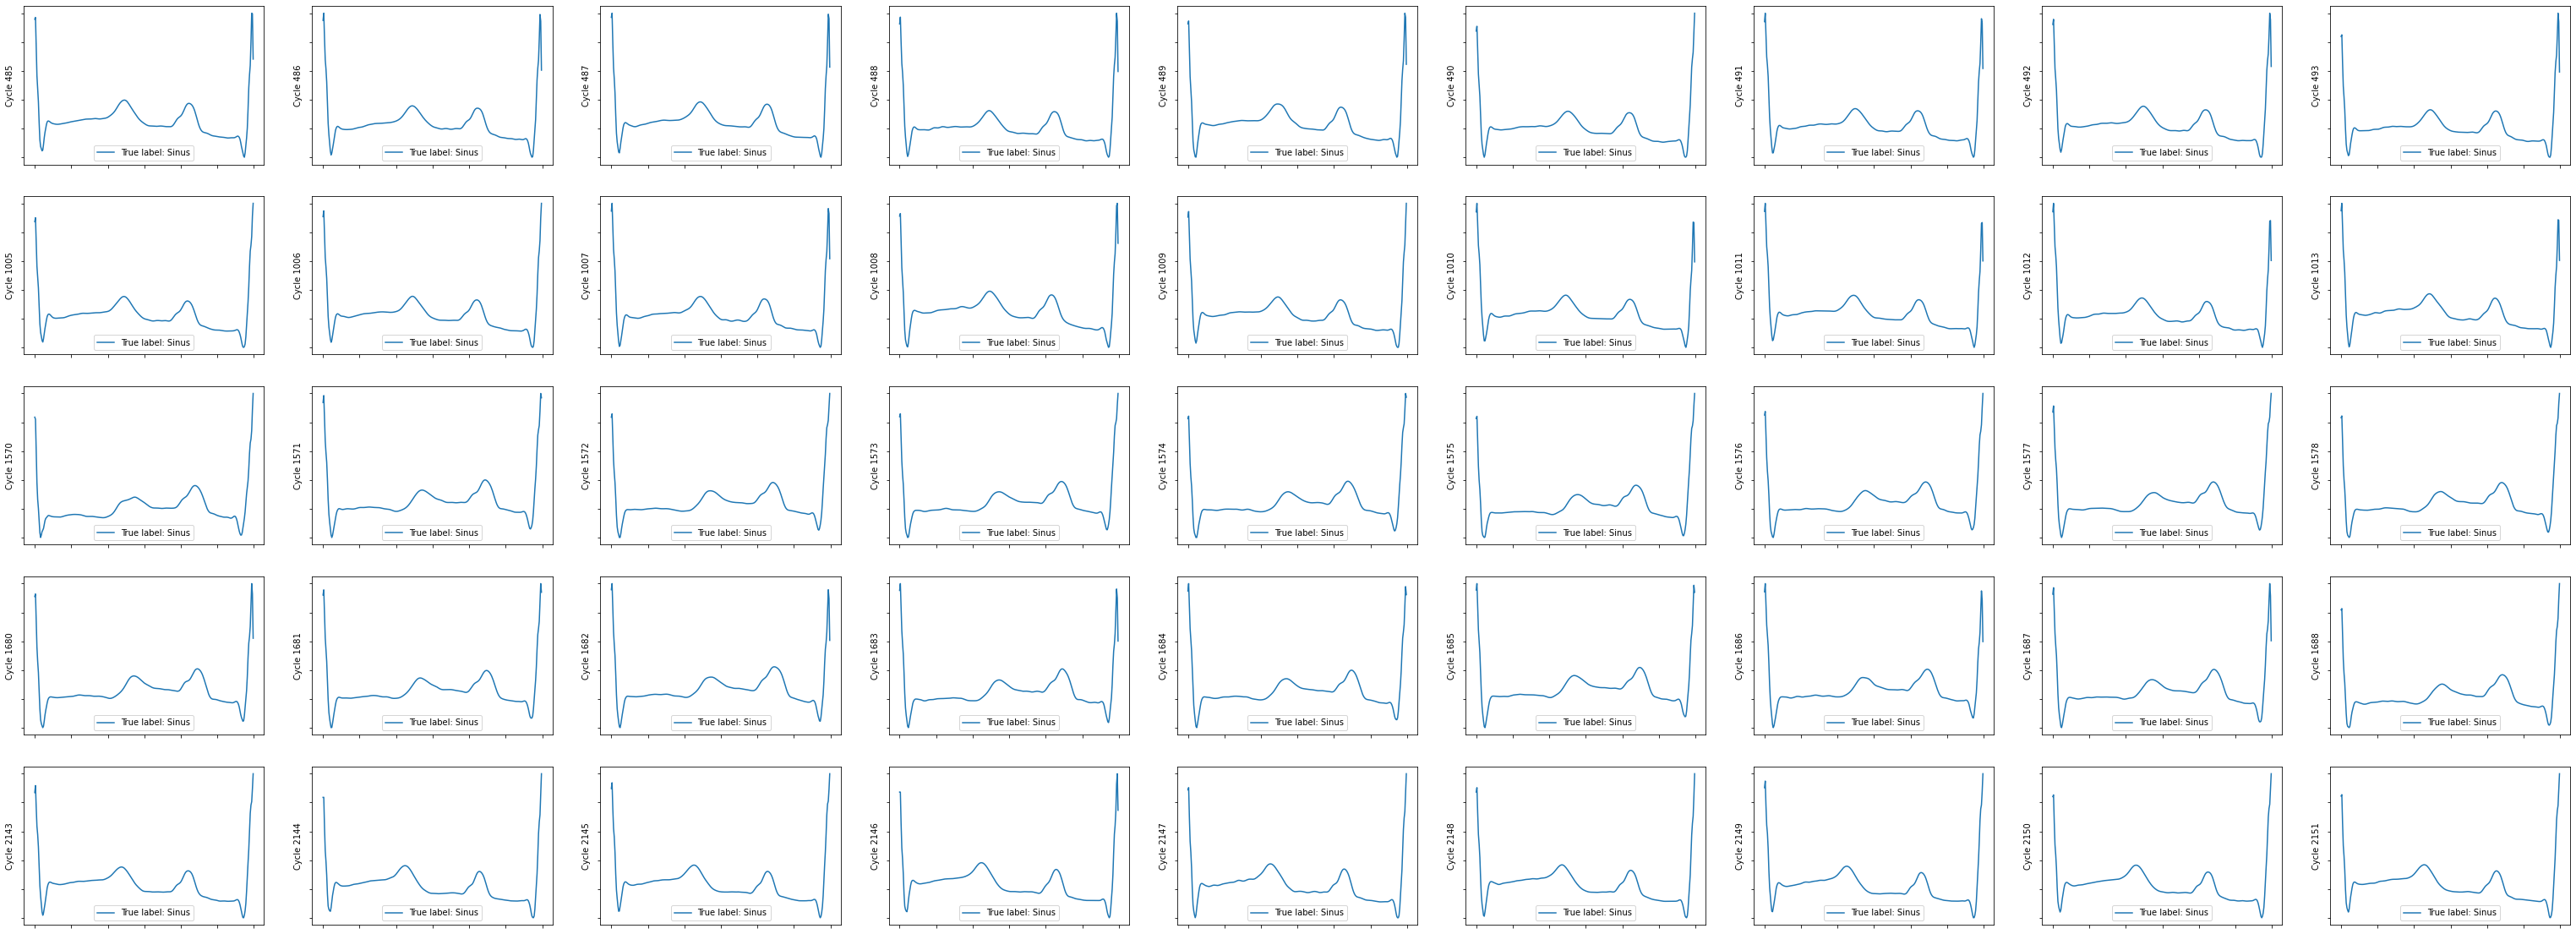

In [45]:
patient_ID = patient_ID_list_test[0]
dataset_df = feature_with_ecg_df_test_single_lead
num_random_cycle_to_show = 5
num_cycle_to_show_each_side = 4
seed = 0
Show_ECGs(dataset_df, patient_ID=patient_ID, num_random_cycle_to_show=num_random_cycle_to_show,
          num_cycle_to_show_each_side=num_cycle_to_show_each_side, seed=seed)

In [42]:
patient_ID = patient_ID_list_test[0]
dataset_df = feature_with_ecg_df_test_single_lead.query(f"label == 1")
num_random_cycle_to_show = 5
num_cycle_to_show_each_side = 4
seed = 0
Show_ECGs(dataset_df, patient_ID=patient_ID, num_random_cycle_to_show=num_random_cycle_to_show,
          num_cycle_to_show_each_side=num_cycle_to_show_each_side, seed=seed)

Patient ID: 756172
# Available heartbeats = 0
# Sinus beats = 0
# JET beats = 0
No samples available.


Patient ID: 424072
# Available heartbeats = 1529
# Sinus beats = 0
# JET beats = 1529


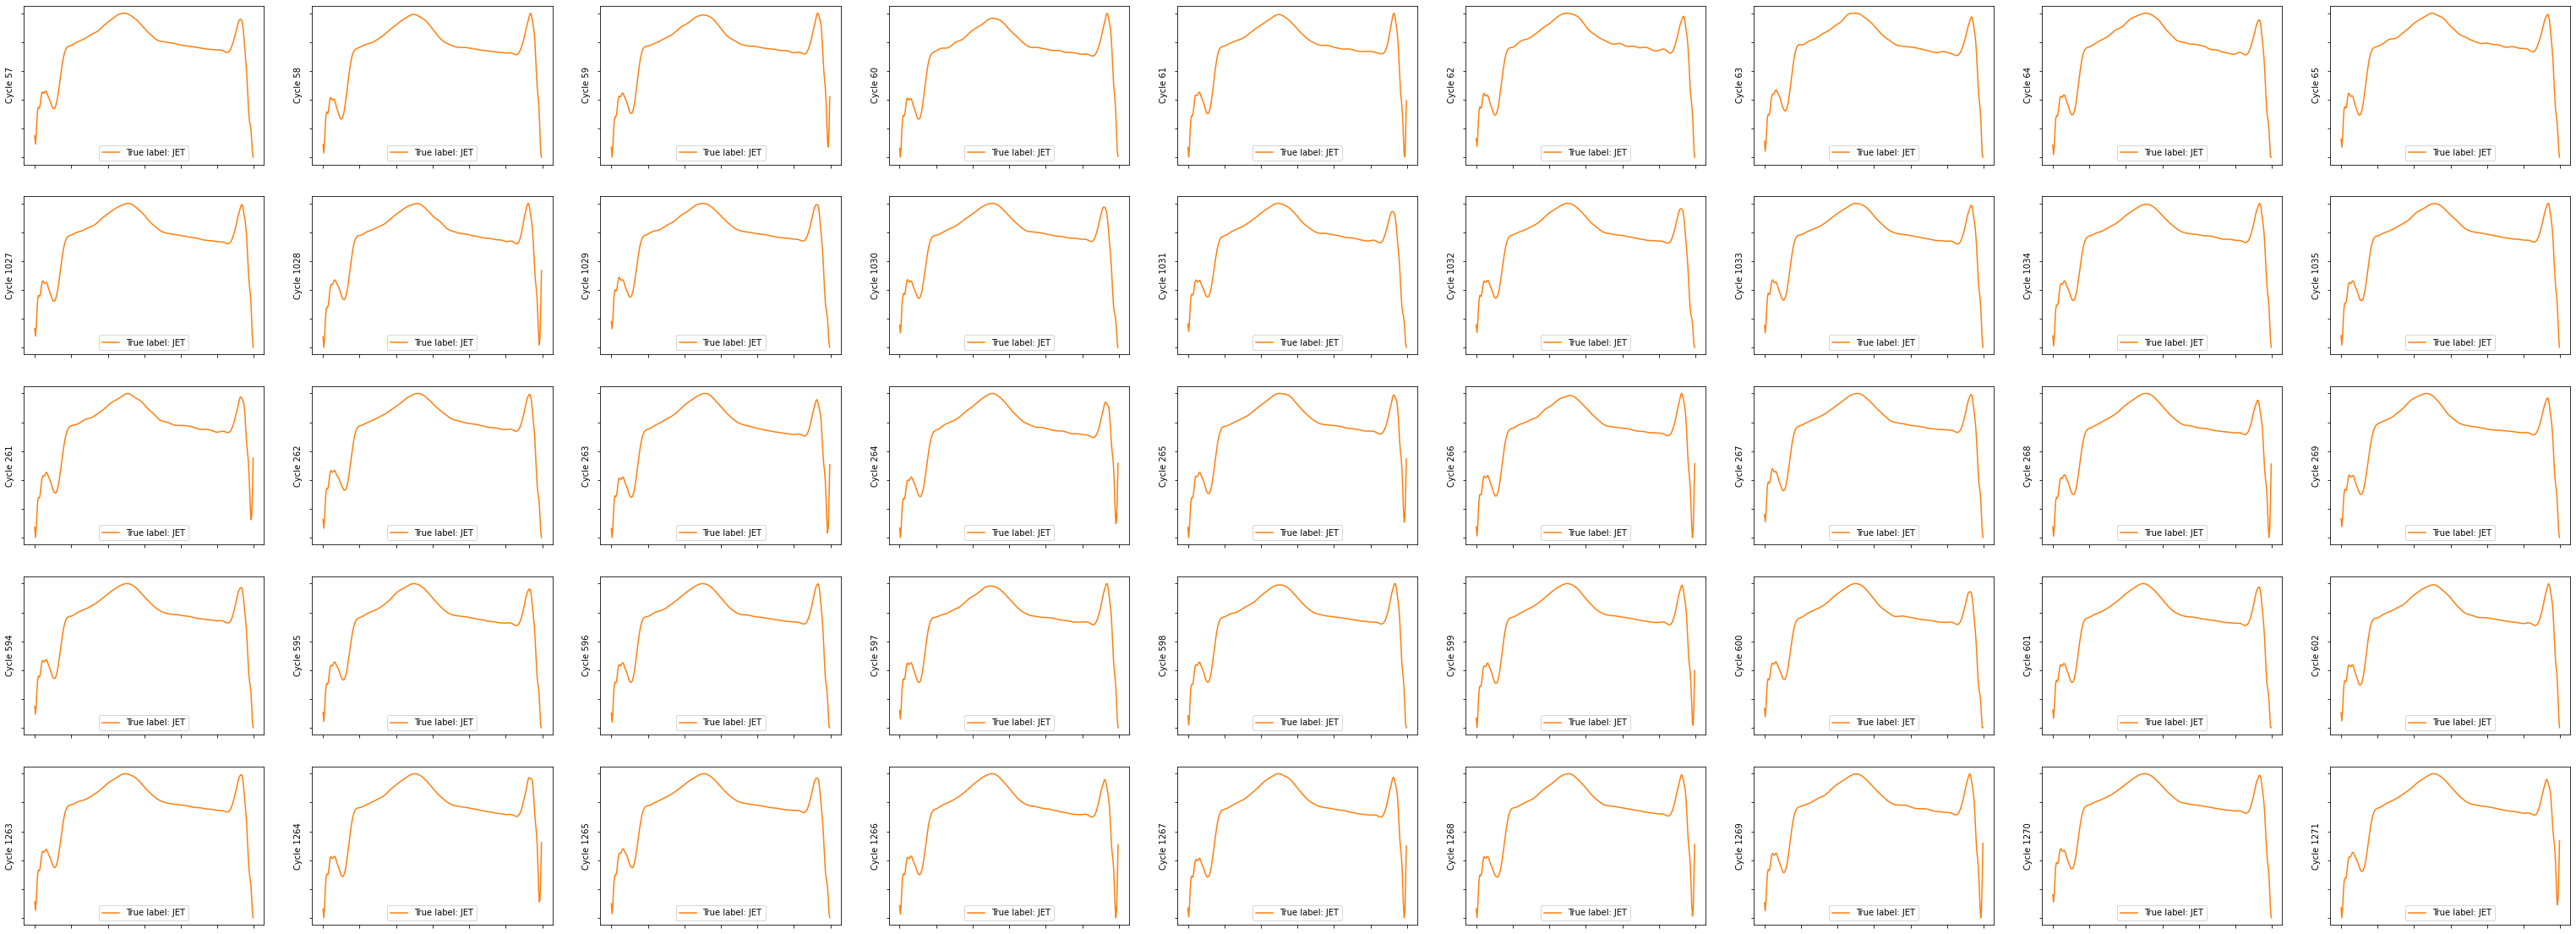

In [43]:
patient_ID = patient_ID_list_test[1]
dataset_df = feature_with_ecg_df_test_single_lead.query(f"label == 1")
num_random_cycle_to_show = 5
num_cycle_to_show_each_side = 4
seed = 1
Show_ECGs(dataset_df, patient_ID=patient_ID, num_random_cycle_to_show=num_random_cycle_to_show,
          num_cycle_to_show_each_side=num_cycle_to_show_each_side, seed=seed)

# Available heartbeats = 68589
# Sinus beats = 68589
# JET beats = 0


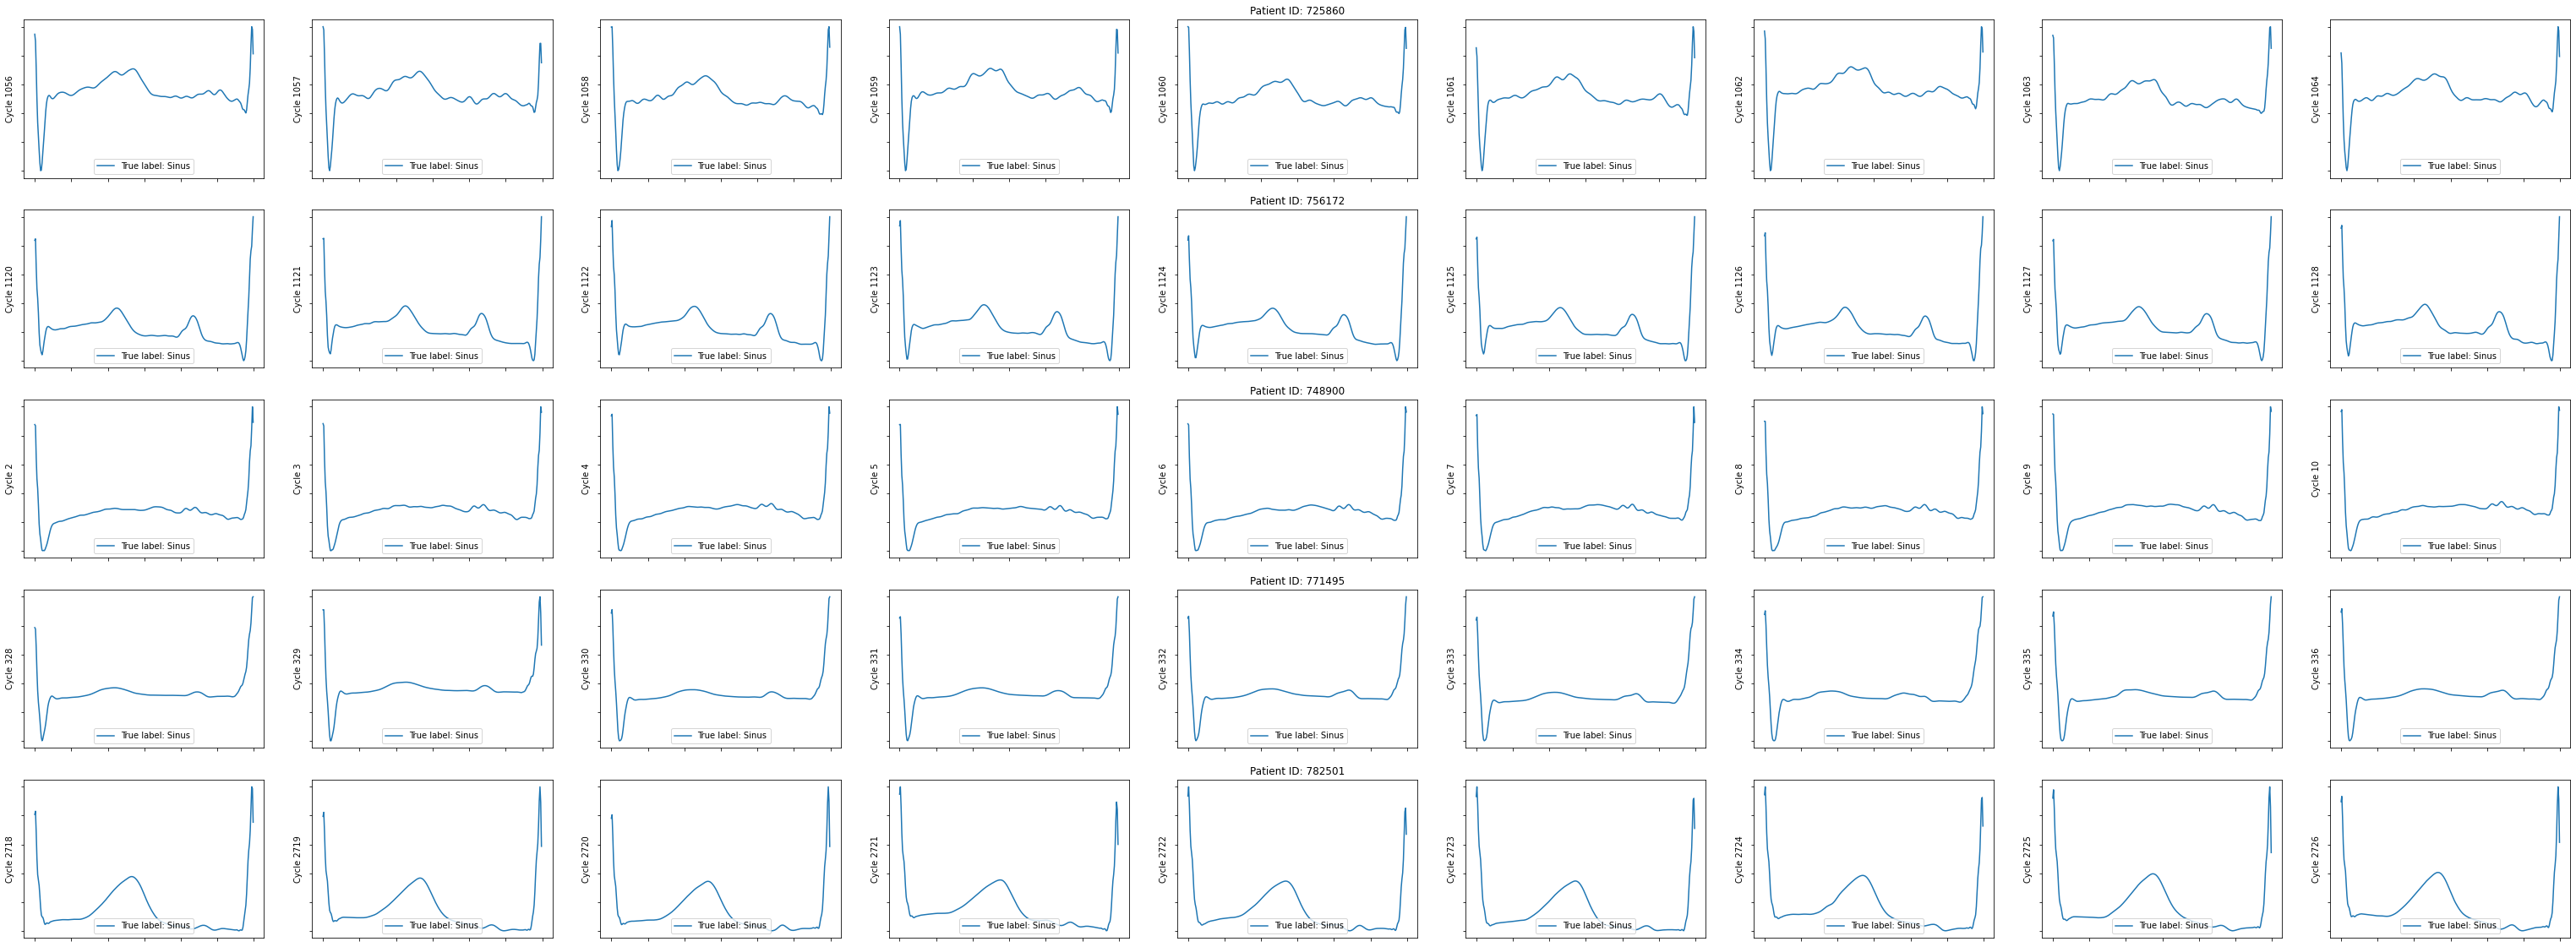

In [51]:
dataset_df = feature_with_ecg_df_test_single_lead.query(f"label == 0")
num_random_cycle_to_show = 5
num_cycle_to_show_each_side = 4
seed = 1
Show_ECGs(dataset_df, num_random_cycle_to_show=num_random_cycle_to_show,
          num_cycle_to_show_each_side=num_cycle_to_show_each_side, seed=seed)

# Available heartbeats = 45823
# Sinus beats = 0
# JET beats = 45823


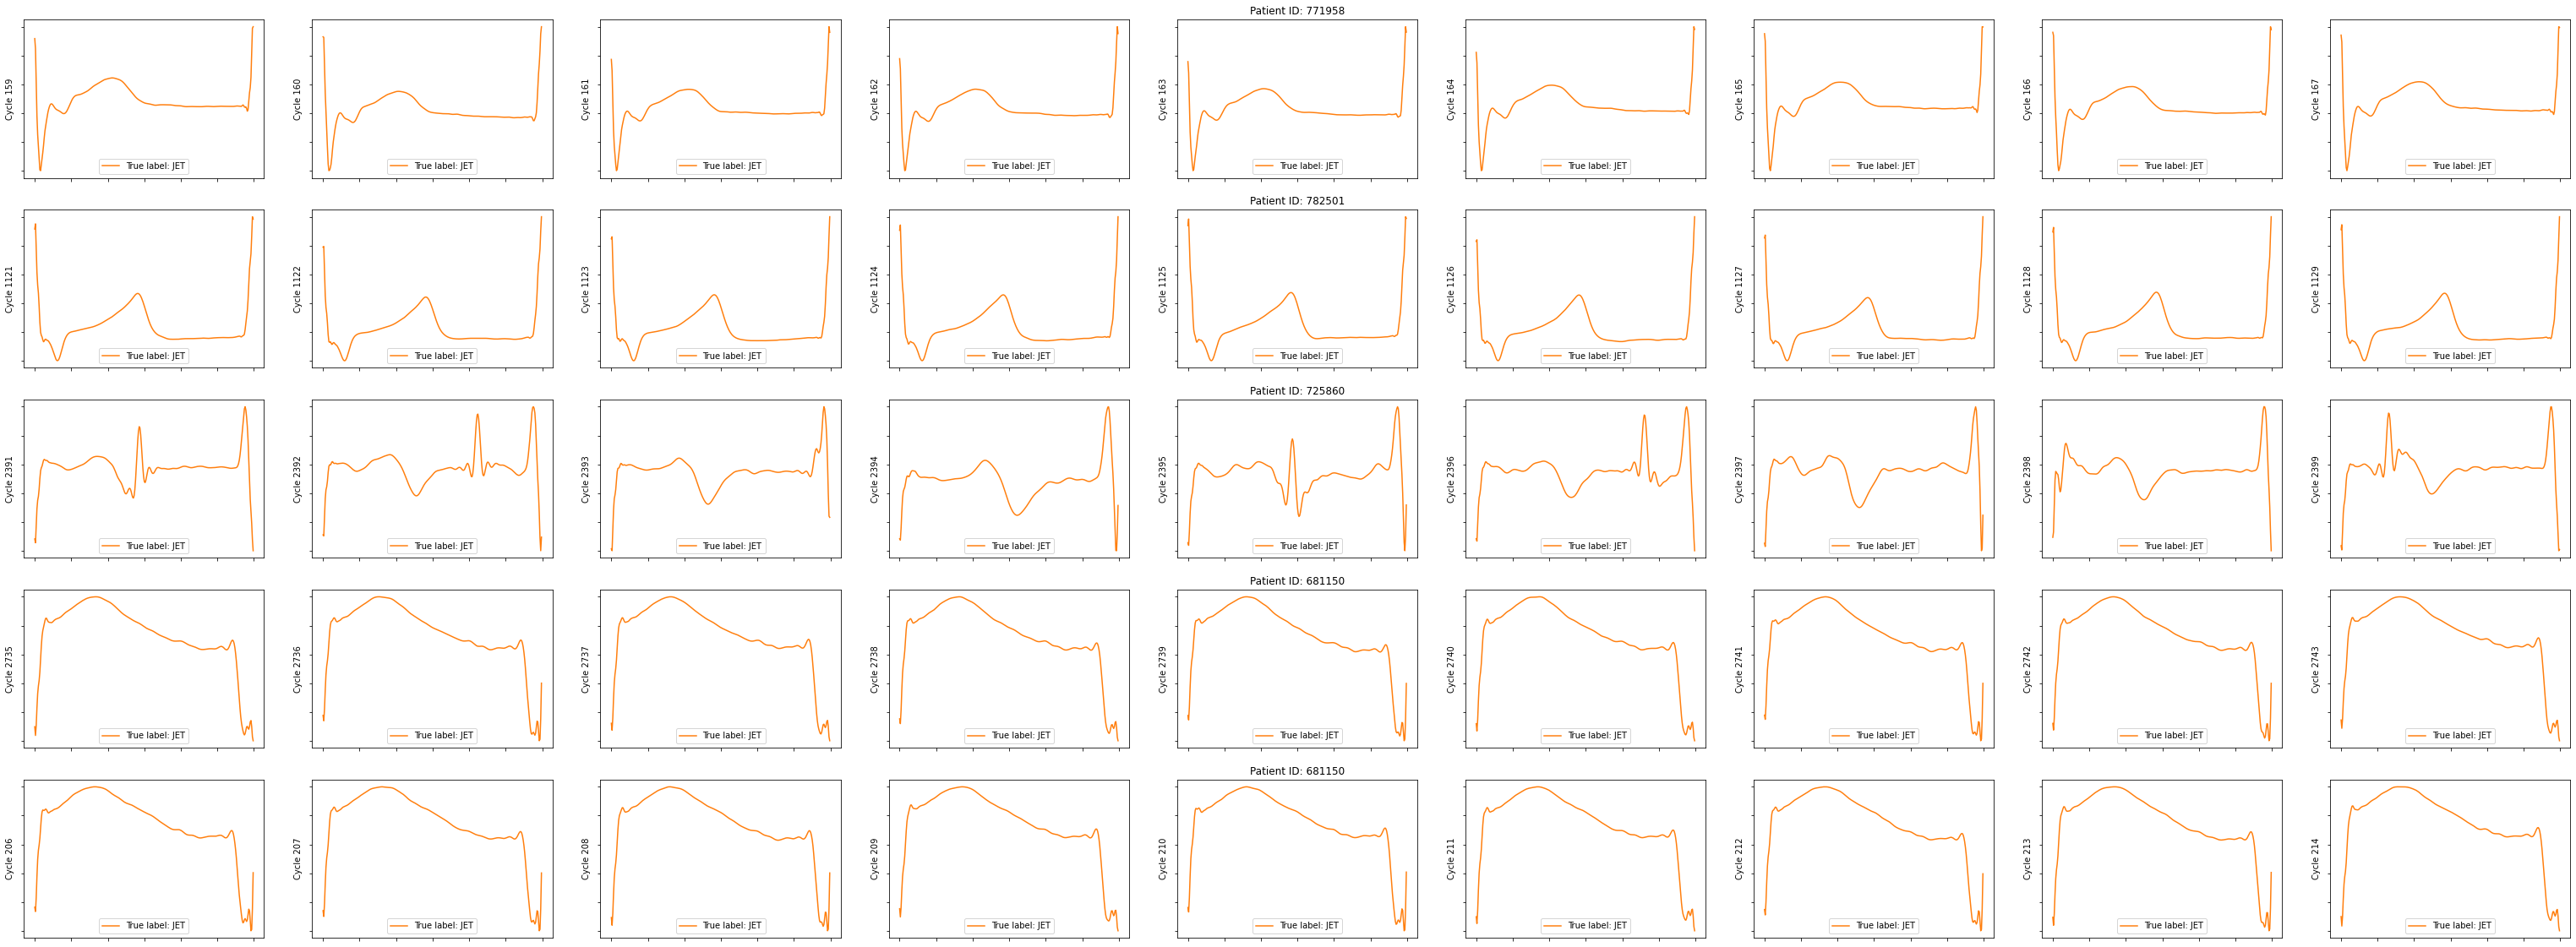

In [52]:
dataset_df = feature_with_ecg_df_test_single_lead.query(f"label == 1")
num_random_cycle_to_show = 5
num_cycle_to_show_each_side = 4
seed = 1
Show_ECGs(dataset_df, num_random_cycle_to_show=num_random_cycle_to_show,
          num_cycle_to_show_each_side=num_cycle_to_show_each_side, seed=seed)

Patient ID: 725860
# Available heartbeats = 6839
# Sinus beats = 0
# JET beats = 6839


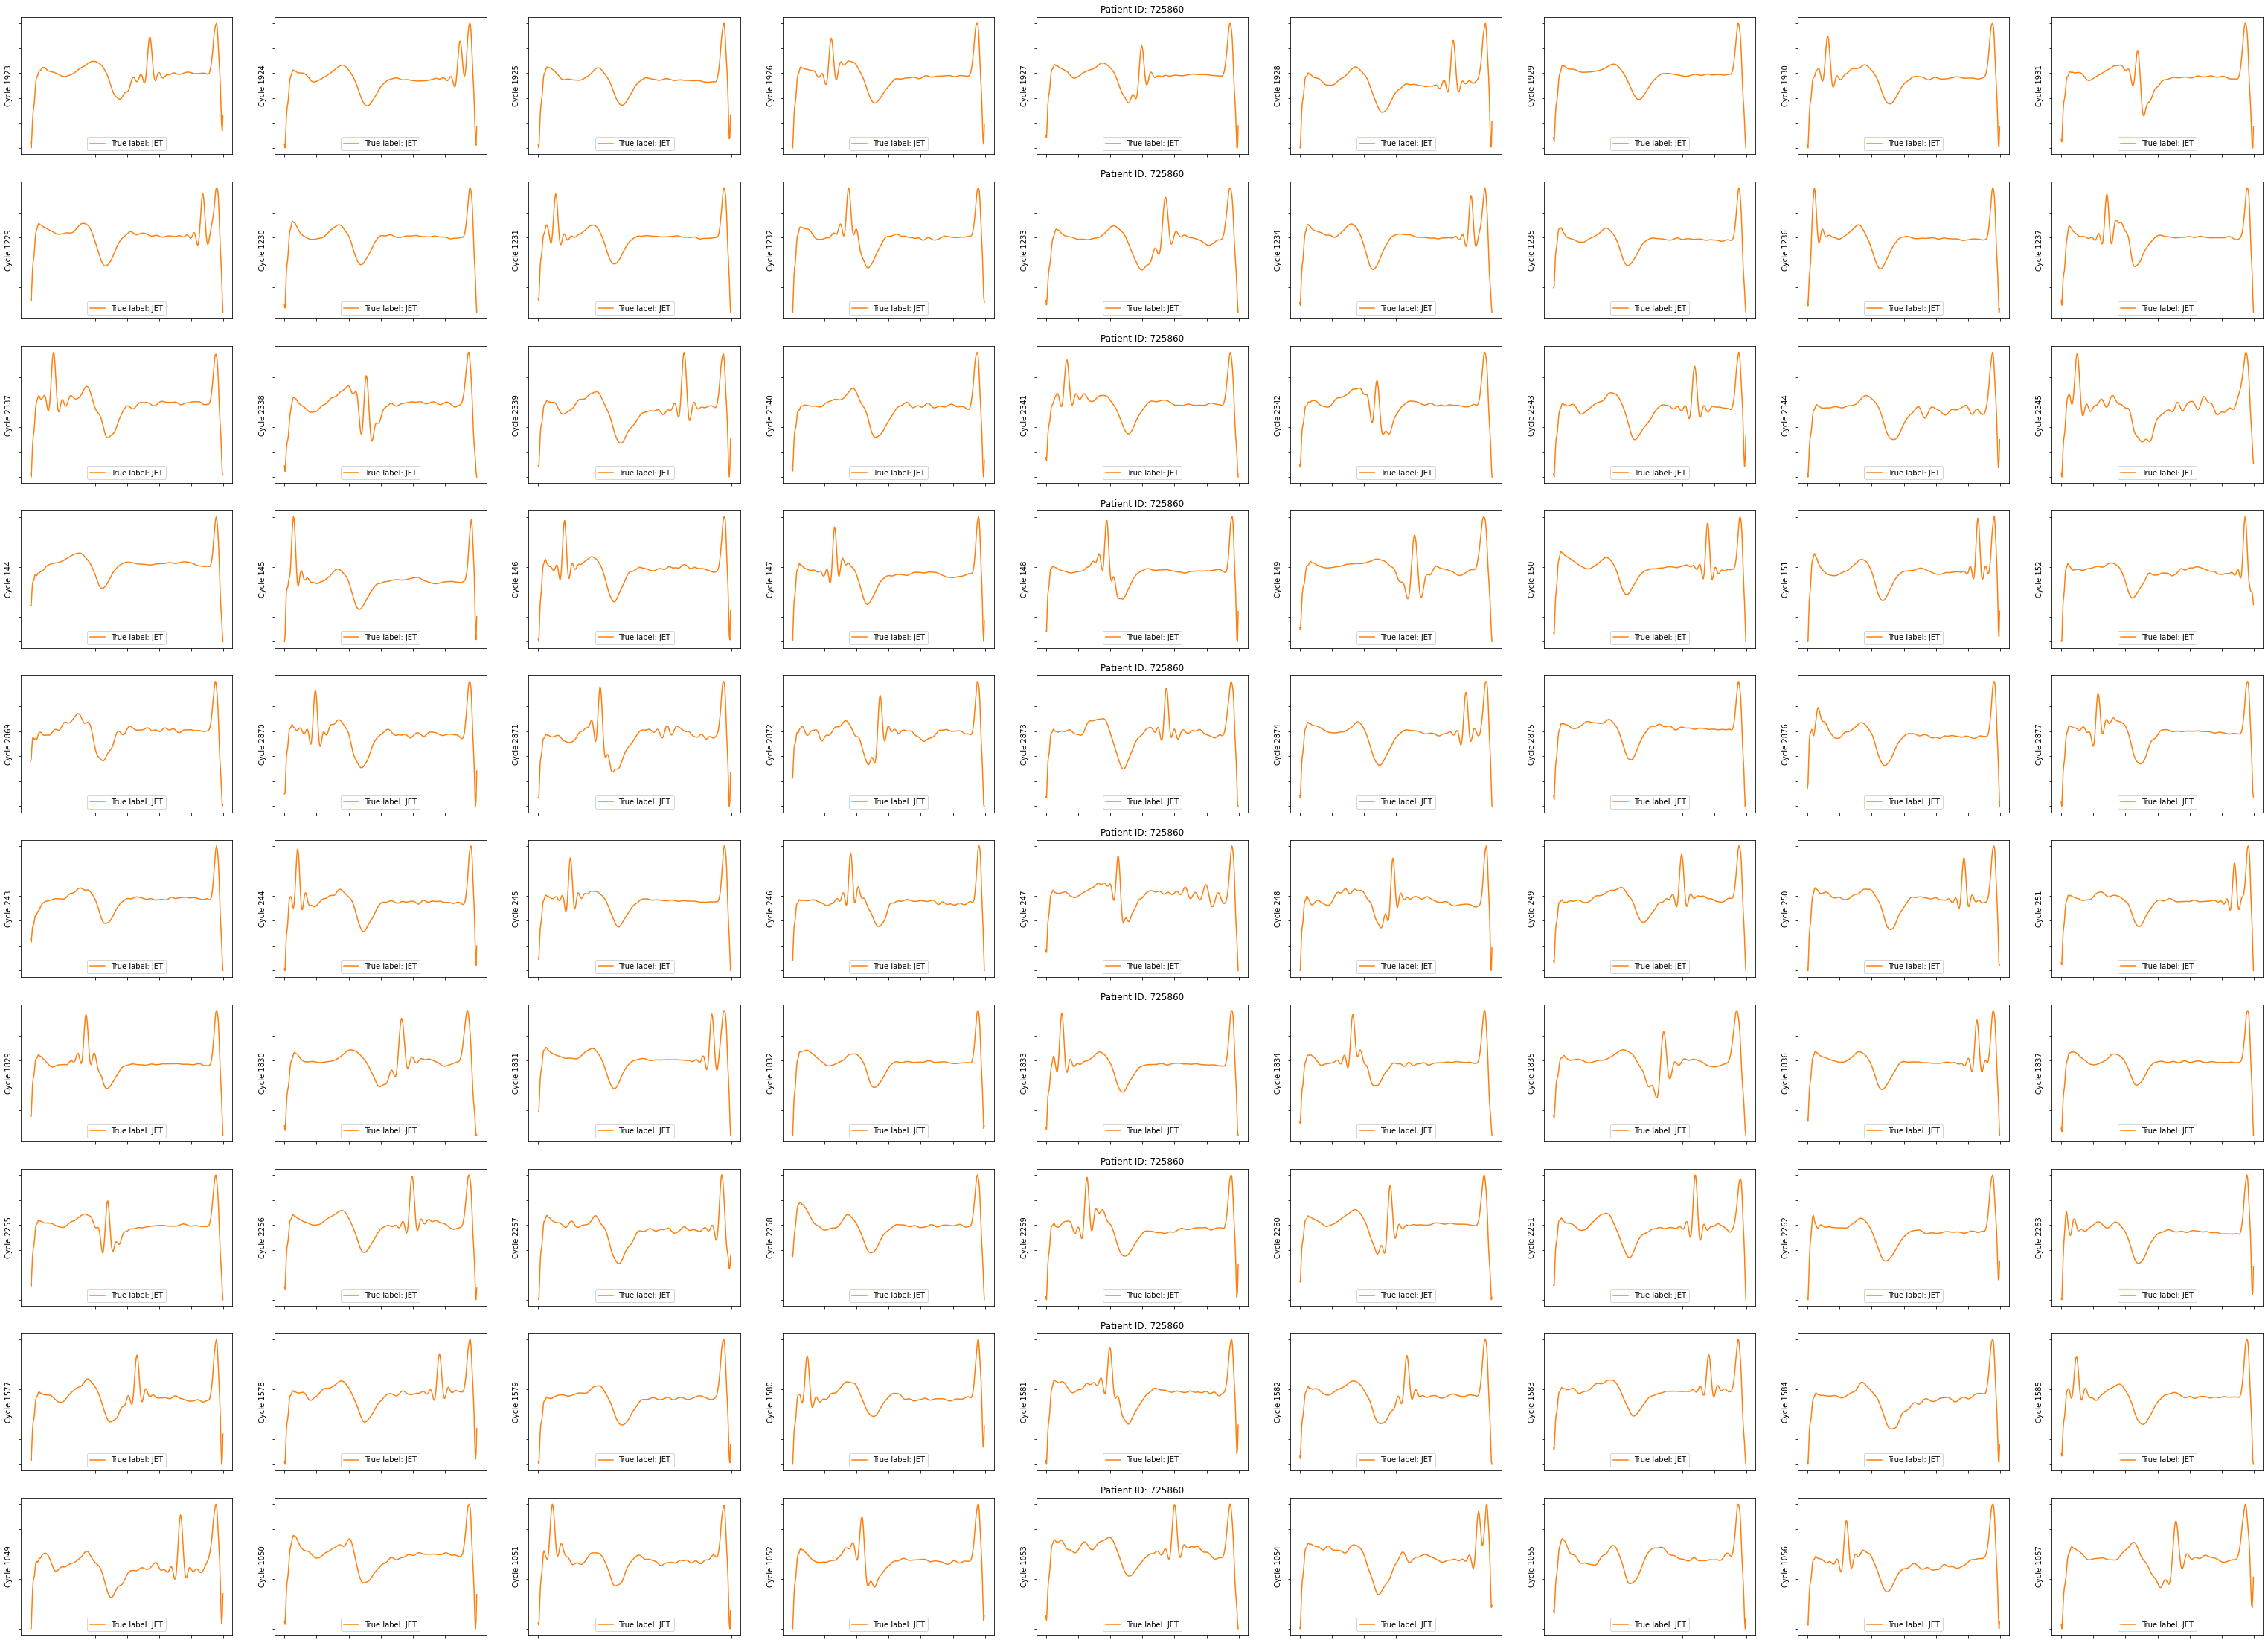

In [50]:
patient_ID = 725860
dataset_df = feature_with_ecg_df_test_single_lead.query(f"label == 1")
num_random_cycle_to_show = 10
num_cycle_to_show_each_side = 4
seed = 1
Show_ECGs(dataset_df, patient_ID=patient_ID, num_random_cycle_to_show=num_random_cycle_to_show,
          num_cycle_to_show_each_side=num_cycle_to_show_each_side, seed=seed)